# Phân Tích Các Bài Báo Về COVID-19

Trong thử thách này, chúng ta sẽ tiếp tục với chủ đề đại dịch COVID và tập trung vào việc xử lý các bài báo khoa học về chủ đề này. Có một [Bộ Dữ Liệu CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) với hơn 7000 bài báo (tại thời điểm viết) về COVID, được cung cấp kèm theo siêu dữ liệu và tóm tắt (và khoảng một nửa trong số đó cũng có toàn văn).

Một ví dụ đầy đủ về việc phân tích bộ dữ liệu này bằng cách sử dụng dịch vụ nhận thức [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) được mô tả [trong bài viết blog này](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Chúng ta sẽ thảo luận phiên bản đơn giản hóa của phân tích này.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Lấy Dữ Liệu

Đầu tiên, chúng ta cần lấy metadata cho các bài báo CORD mà chúng ta sẽ làm việc.

**LƯU Ý**: Chúng tôi không cung cấp một bản sao của tập dữ liệu trong kho lưu trữ này. Bạn có thể cần tải xuống tệp [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) từ [tập dữ liệu này trên Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Có thể cần phải đăng ký với Kaggle. Bạn cũng có thể tải xuống tập dữ liệu mà không cần đăng ký [từ đây](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), nhưng nó sẽ bao gồm toàn bộ văn bản đầy đủ bên cạnh tệp metadata.

Chúng ta sẽ cố gắng lấy dữ liệu trực tiếp từ nguồn trực tuyến, tuy nhiên, nếu không thành công, bạn cần tải dữ liệu như đã mô tả ở trên. Ngoài ra, việc tải dữ liệu về cũng hợp lý nếu bạn dự định thử nghiệm thêm, để tiết kiệm thời gian chờ đợi.

> **LƯU Ý** rằng tập dữ liệu khá lớn, khoảng 1 Gb, và dòng mã sau đây có thể mất nhiều thời gian để hoàn thành! (~5 phút)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Chúng ta sẽ chuyển đổi cột ngày xuất bản sang `datetime`, và vẽ biểu đồ histogram để xem phạm vi của các ngày xuất bản.


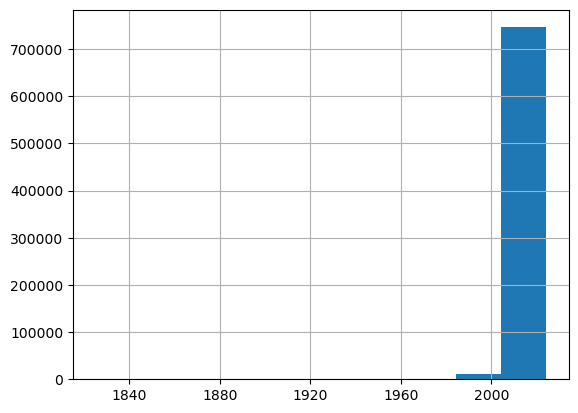

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Trích xuất Dữ liệu Có cấu trúc

Hãy xem chúng ta có thể dễ dàng trích xuất loại thông tin nào từ các bản tóm tắt. Một điều có thể chúng ta quan tâm là xem các chiến lược điều trị nào đang tồn tại và cách chúng phát triển theo thời gian. Để bắt đầu, chúng ta có thể tự tay tổng hợp danh sách các loại thuốc có thể được sử dụng để điều trị COVID, cũng như danh sách các chẩn đoán. Sau đó, chúng ta sẽ xem xét chúng và tìm kiếm các thuật ngữ tương ứng trong các bản tóm tắt của các bài báo.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Chúng tôi đã thêm một loạt các cột vào dataframe của mình, chứa số lần một loại thuốc/chẩn đoán cụ thể xuất hiện trong phần tóm tắt.

> **Lưu ý** rằng chúng tôi thêm khoảng trắng vào đầu từ khi tìm kiếm một chuỗi con. Nếu không làm vậy, chúng tôi có thể nhận được kết quả sai, vì *chloroquine* cũng sẽ được tìm thấy bên trong chuỗi con *hydroxychloroquine*. Ngoài ra, chúng tôi buộc phải chuyển đổi cột tóm tắt sang `str` để loại bỏ lỗi - hãy thử loại bỏ `str` và xem điều gì xảy ra.

Để làm việc với dữ liệu dễ dàng hơn, chúng tôi có thể trích xuất khung con chỉ chứa số lượng thuốc, và tính toán tổng số lần xuất hiện. Điều này cho chúng tôi biết loại thuốc phổ biến nhất:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

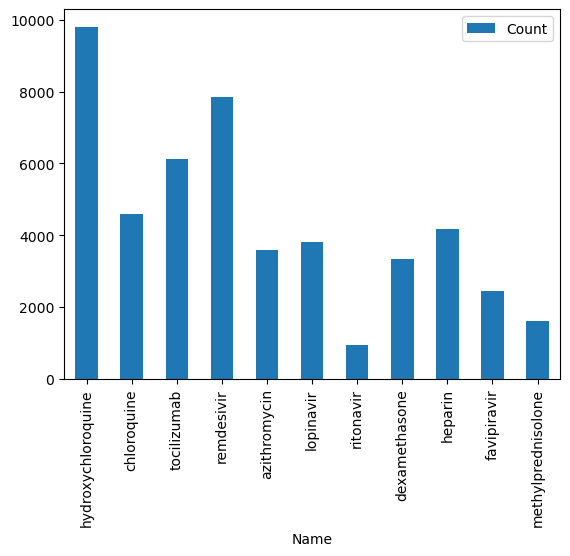

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Tìm kiếm Xu hướng trong Chiến lược Điều trị

Trong ví dụ trên, chúng ta đã sử dụng `sum` để tính tổng tất cả các giá trị, nhưng chúng ta cũng có thể thực hiện điều này theo từng tháng:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

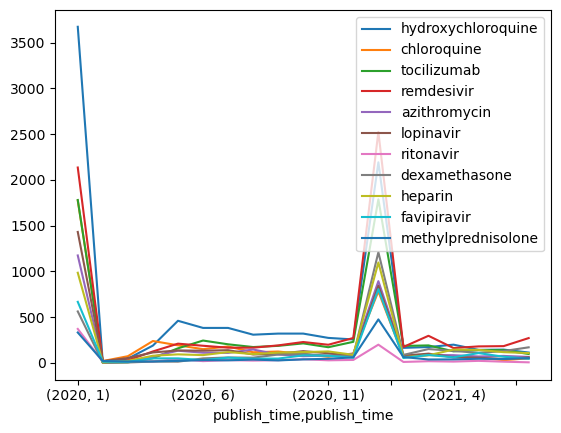

In [152]:
dfmt.plot()
plt.show()

Một quan sát thú vị là chúng ta có những đỉnh lớn tại hai thời điểm: tháng 1 năm 2020 và tháng 1 năm 2021. Điều này xảy ra do một số bài báo không có ngày xuất bản được chỉ định rõ ràng, và chúng được ghi nhận là tháng 1 của năm tương ứng.

Để hiểu rõ hơn về dữ liệu, hãy cùng trực quan hóa chỉ một vài loại thuốc. Chúng ta cũng sẽ "xóa" dữ liệu của tháng 1 và thay thế bằng một giá trị trung bình nào đó, nhằm tạo ra biểu đồ đẹp hơn:


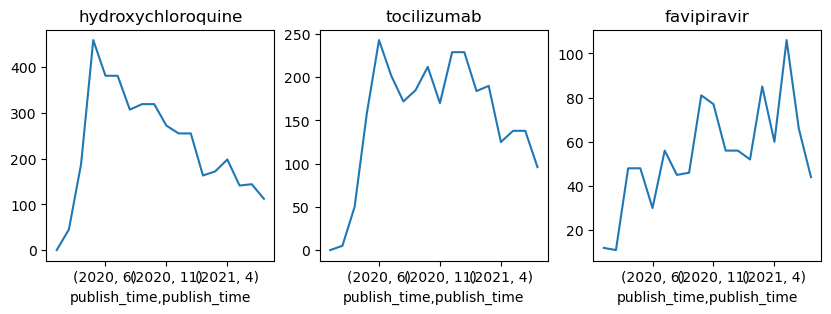

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

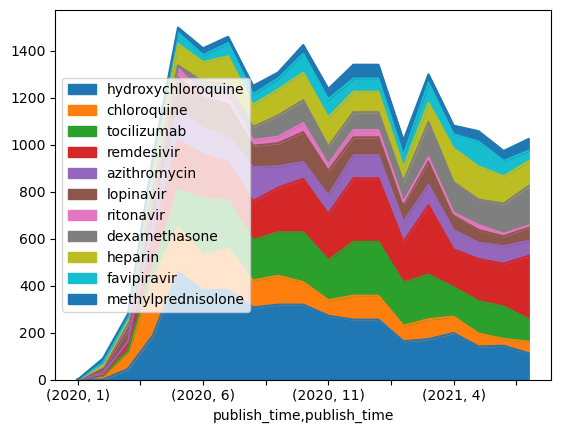

In [154]:
dfmt.plot.area()
plt.show()

Thậm chí hơn nữa, chúng ta có thể tính toán mức độ phổ biến tương đối theo phần trăm:


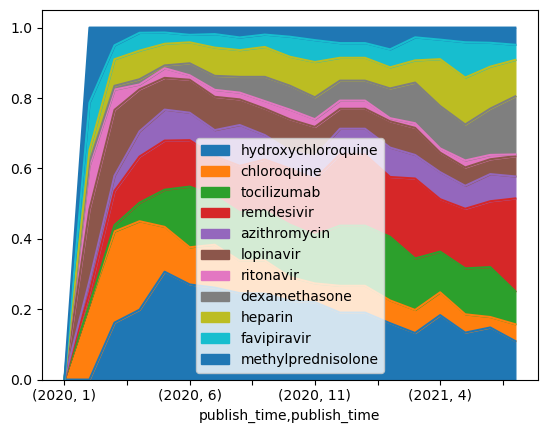

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Tính toán sự tương ứng giữa thuốc và chẩn đoán

Một trong những mối quan hệ thú vị nhất mà chúng ta có thể tìm kiếm là cách các chẩn đoán khác nhau được điều trị bằng các loại thuốc khác nhau. Để hình dung điều này, chúng ta cần tính toán **bản đồ tần suất đồng xuất hiện**, cho thấy số lần hai thuật ngữ được đề cập trong cùng một bài báo.

Bản đồ này về cơ bản là một ma trận 2D, tốt nhất được biểu diễn bằng **numpy array**. Chúng ta sẽ tính toán bản đồ này bằng cách đi qua tất cả các bản tóm tắt và đánh dấu các thực thể xuất hiện ở đó:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Một trong những cách để hình dung ma trận này là vẽ một **bản đồ nhiệt**:


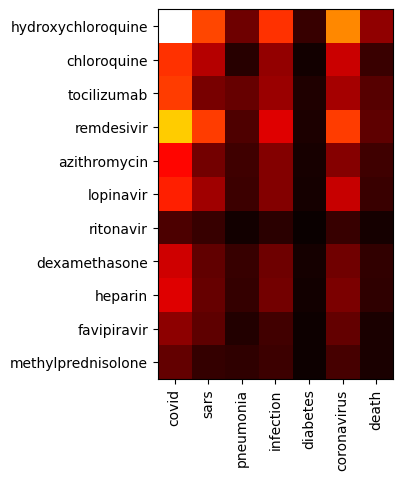

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Tuy nhiên, một cách trực quan hóa thậm chí còn tốt hơn là sử dụng biểu đồ **Sankey**! `matplotlib` không hỗ trợ sẵn loại biểu đồ này, vì vậy chúng ta sẽ phải sử dụng [Plotly](https://plotly.com/python/) như được mô tả [trong hướng dẫn này](https://plotly.com/python/sankey-diagram/).

Để tạo biểu đồ sankey bằng plotly, chúng ta cần xây dựng các danh sách sau:
* Danh sách `all_nodes` chứa tất cả các nút trong đồ thị, bao gồm cả thuốc và chẩn đoán
* Danh sách các chỉ số nguồn và đích - những danh sách này sẽ cho biết các nút nào đi về phía bên trái và nút nào đi về phía bên phải của biểu đồ
* Danh sách tất cả các liên kết, mỗi liên kết bao gồm:
   - Chỉ số nguồn trong mảng `all_nodes`
   - Chỉ số đích
   - Giá trị biểu thị độ mạnh của liên kết. Đây chính là giá trị từ ma trận đồng xuất hiện của chúng ta.
   - Tùy chọn màu sắc của liên kết. Chúng ta sẽ tạo một tùy chọn để làm nổi bật một số thuật ngữ nhằm tăng tính rõ ràng

Mã chung để vẽ biểu đồ sankey được cấu trúc dưới dạng một hàm `sankey` riêng biệt, hàm này nhận hai danh sách (các danh mục nguồn và đích) và ma trận đồng xuất hiện. Nó cũng cho phép chúng ta chỉ định ngưỡng và loại bỏ tất cả các liên kết yếu hơn ngưỡng đó - điều này giúp biểu đồ bớt phức tạp hơn một chút.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Kết luận

Bạn đã thấy rằng chúng ta có thể sử dụng các phương pháp khá đơn giản để trích xuất thông tin từ các nguồn dữ liệu không có cấu trúc, chẳng hạn như văn bản. Trong ví dụ này, chúng ta đã sử dụng danh sách các loại thuốc có sẵn, nhưng sẽ mạnh mẽ hơn nhiều nếu sử dụng các kỹ thuật xử lý ngôn ngữ tự nhiên (NLP) để thực hiện việc trích xuất thực thể từ văn bản. Trong [bài viết trên blog này](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/), chúng tôi mô tả cách sử dụng các dịch vụ đám mây để trích xuất thực thể. Một lựa chọn khác là sử dụng các thư viện NLP của Python như [NLTK](https://www.nltk.org/) - một cách tiếp cận để trích xuất thông tin từ văn bản bằng NLTK được mô tả [tại đây](https://www.nltk.org/book/ch07.html).


## Thử thách

Tiếp tục nghiên cứu dữ liệu bài báo về COVID theo các hướng sau:

1. Xây dựng ma trận đồng xuất hiện của các loại thuốc khác nhau và xem loại thuốc nào thường xuất hiện cùng nhau (tức là được đề cập trong cùng một tóm tắt). Bạn có thể chỉnh sửa mã để xây dựng ma trận đồng xuất hiện cho các loại thuốc và chẩn đoán.
2. Trực quan hóa ma trận này bằng biểu đồ nhiệt (heatmap).
3. Nếu muốn thử thách thêm, bạn có thể trực quan hóa sự đồng xuất hiện của các loại thuốc bằng [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [Thư viện này](https://pypi.org/project/chord/) có thể giúp bạn vẽ chord diagram.
4. Một thử thách khác, hãy thử trích xuất liều lượng của các loại thuốc khác nhau (chẳng hạn như **400mg** trong *uống 400mg chloroquine mỗi ngày*) bằng cách sử dụng biểu thức chính quy, và xây dựng dataframe hiển thị các liều lượng khác nhau cho từng loại thuốc. **Lưu ý**: xem xét các giá trị số nằm gần tên thuốc trong văn bản.



---

**Tuyên bố miễn trừ trách nhiệm**:  
Tài liệu này đã được dịch bằng dịch vụ dịch thuật AI [Co-op Translator](https://github.com/Azure/co-op-translator). Mặc dù chúng tôi cố gắng đảm bảo độ chính xác, xin lưu ý rằng các bản dịch tự động có thể chứa lỗi hoặc không chính xác. Tài liệu gốc bằng ngôn ngữ bản địa nên được coi là nguồn thông tin chính thức. Đối với các thông tin quan trọng, nên sử dụng dịch vụ dịch thuật chuyên nghiệp từ con người. Chúng tôi không chịu trách nhiệm về bất kỳ sự hiểu lầm hoặc diễn giải sai nào phát sinh từ việc sử dụng bản dịch này.
